# Glove Embedding

- In this notebook there is an implementation of the model GloVe, a model developed by Standford to learn word embeddings, using tensorflow

In [4]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from random import choices
from scipy.sparse import dok_matrix, hstack, vstack
from scipy.spatial.distance import cosine
from scipy.sparse.linalg import svds, inv

from sklearn.decomposition import PCA

from tensorflow.keras.layers import Input, Dot, Embedding, Dense, Flatten, Lambda, Concatenate, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [2]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [3]:
M = len(all_words)
M

100649

In [5]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

In [6]:
def count_word_coocurrence(docs, vocab, wsize=10):
    term_term_dict = {}
    for doc in tqdm(docs):
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    M = len(vocab)
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [7]:
word_cooc_matrix = count_word_coocurrence(docs, all_words, wsize=5)

  0%|          | 0/397123 [00:00<?, ?it/s]

In [8]:
def get_training_sets(cooc: dok_matrix):
    """
    Tranforms the term-term matrix into a transactional context-target dataset
    """
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [9]:
X, y = get_training_sets(word_cooc_matrix)
EMB_SIZE=50

In [10]:
target = Input(shape=1, name="context_input")
context = Input(shape=1, name="target_input")

embed_layer = Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot_layer = Dot(axes=2)( [ embed_target, embed_context ] )
flat = Flatten()(dot_layer)

model = Model(inputs=[ target, context ], outputs=flat)

In [11]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )

In [12]:
model.compile(optimizer="adam", loss=loss)

In [15]:
model.fit([ X[:,0], X[:,1] ], y, epochs=1, batch_size=512)

11983/11983 [==============================] - 141s 12ms/step - loss: 17.0593


In [17]:
embed_vectors = model.get_weights()[0]

In [18]:
pca = PCA().fit_transform(embed_vectors)

In [24]:
np.argsort([ 
    euclidean(
        pca[word2int("cnn")], 
        pca[i]
    ) for i in range(len(pca))
])[:15]

array([  992,   489,   488,    68,   450, 31480, 25362, 56725,  1063,
       36925,  1292, 56726, 41913, 60365,  2767], dtype=int64)

In [25]:
int2word(489)

'cnns'

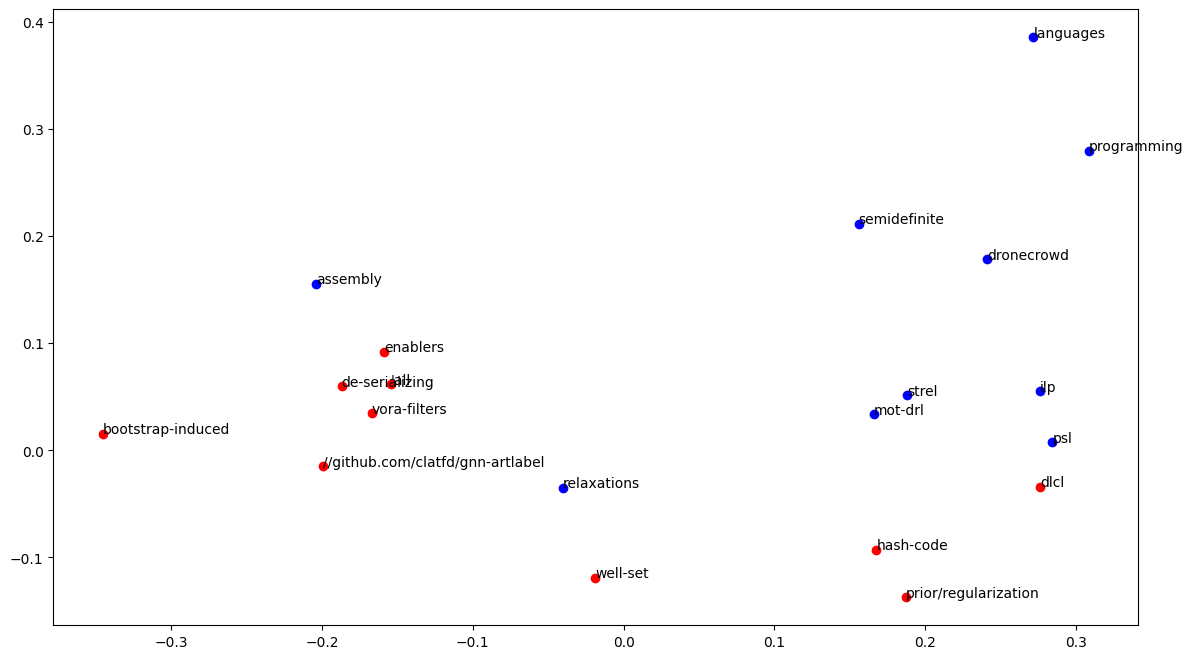

In [29]:
k=10
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("programming")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))